<a href="https://colab.research.google.com/github/sz549/Github_Intro_Guide/blob/Tianjian_Zhang_Amsterdam_replication/Tianjian_Zhang_Amsterdam_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## My notes

加权解决异方差？加权按照离4的距离去加权，越近的话权重越大


$S=\sum_{i=1}^n W_{i i} r_i{ }^2, \quad W_{i i}=\frac{1}{{\sigma_i}^2}$

离4越近，权重越大，当然最小的权重不能比0小

关于booked的假设？available+booked+bloced = 365

rd是一种因果推断的方法，简单来说就是对阈值两端分别进行某种回归，其中rd estimator指的是阈值处两组回归的垂直距离，se值得是rd estimator的standard error，按理说应该越小越好

注意到在这个样本中score=4是低于平均值的，意味着可能分越低，越多（新）评论就会发生complaints？

## Revised code

In [29]:
!cd "/content/data_rd/MyDrive/data_rd"
!git clone https://github.com/sz549/Github_Intro_Guide.git
#!cd Github_Intro_Guide
#!git lfs install
#!git checkout Tianjian_Zhang_Amsterdam_replication
!git add "/content/data_rd/MyDrive/data_rd"

fatal: destination path 'Github_Intro_Guide' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [10]:
from google.colab import drive
drive.mount('/content/data_rd')

Drive already mounted at /content/data_rd; to attempt to forcibly remount, call drive.mount("/content/data_rd", force_remount=True).


In [18]:
import os
import pandas as pd
#import gzip
import matplotlib.pyplot as plt
import ast
import numpy as np

# Path to the directory containing the files. Change the city to the city you choose.
directory = '/content/data_rd/MyDrive/data_rd/'
#file_path = os.path.join(directory, 'listings.csv')
# Initialize an empty list to store the dataframes
dataframes = []
print(os.listdir(directory))
#Loop over the files in the directory
#for i in range():
   # if filename.endswith('.csv'):
        # Extract the date from the filename
      #  date = filename.split('_')[1]

        # Create the file path
file_path2 = os.path.join(directory, 'listings (2).csv')
file_path3 = os.path.join(directory, 'listings (3).csv')
file_path4 = os.path.join(directory, 'listings (4).csv')
file_path5 = os.path.join(directory, 'listings (5).csv')
        # Read the csv file
with open(file_path5, 'rt', encoding='utf-8') as f:
    df = pd.read_csv(f)

            # Append the dataframe to the list
    dataframes.append(df)

        # Read the csv file
with open(file_path4, 'rt', encoding='utf-8') as f:
    df = pd.read_csv(f)

            # Append the dataframe to the list
    dataframes.append(df)
with open(file_path3, 'rt', encoding='utf-8') as f:
    df = pd.read_csv(f)

            # Append the dataframe to the list
    dataframes.append(df)

with open(file_path2, 'rt', encoding='utf-8') as f:
    df = pd.read_csv(f)

            # Append the dataframe to the list
    dataframes.append(df)




# Concatenate the dataframes
all_data = pd.concat(dataframes, ignore_index=True)

# Print the head and row count
print(all_data.head())
print(f'Row count: {len(all_data)}')

# Count the number of unique IDs
unique_id_count = all_data['id'].nunique()

# Get the list of all columns
columns_list = all_data.columns.tolist()

# Print the list of columns
print("List of columns in the DataFrame:")
for column in columns_list:
    print(column)

# Print the results
print(f'Number of unique IDs: {unique_id_count}')

#Keep only the columns you are interested in
columns_to_keep = ['id', 'last_scraped', 'host_id', 'host_listings_count', 'host_total_listings_count', 'availability_365', 'number_of_reviews',
                   'number_of_reviews_ltm', 'review_scores_rating', 'reviews_per_month', 'neighbourhood_cleansed',
                   'host_is_superhost', 'host_since', 'host_response_time', 'host_response_rate', 'property_type', 'room_type',
                   'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'availability_30', 'availability_60',
                   'availability_90']
all_data = all_data[columns_to_keep]


# Remove both dollar signs and commas from the 'price' column before converting to float, then to integer
all_data['price'] = all_data['price'].replace({'\$': '', ',': ''}, regex=True).astype(float).astype(int)

# Convert stringified lists into actual lists
all_data['amenities'] = all_data['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of amenities into a single list and count the occurrences of each amenity
amenities_flat_list = [amenity for sublist in all_data['amenities'] for amenity in sublist]
amenities_counts = pd.Series(amenities_flat_list).value_counts()

# Get the top 20 most frequent amenities
top_20_amenities = amenities_counts.nlargest(20).index.tolist()

# Create dummy variables for the top 20 amenities
for amenity in top_20_amenities:
    all_data[amenity] = all_data['amenities'].apply(lambda x: int(amenity in x))

# Drop the original 'amenities' column if it's no longer needed
all_data.drop('amenities', axis=1, inplace=True)

# Sort the DataFrame by 'last_scraped' in descending order to get the latest date first
all_data_sorted = all_data.sort_values('last_scraped', ascending=False)

# Get the date prior to the earliest 'last_scraped' date in the DataFrame
if len(all_data_sorted['last_scraped']) > 1:
    # Use the second to last date as the reference date
    reference_date = all_data_sorted['last_scraped'].iloc[-2]
else:
    # If there's only one date, use the date three months prior as the reference date
    reference_date = all_data_sorted['last_scraped'].iloc[-1] - pd.DateOffset(months=3)

all_data['previous_scraped_date'] = reference_date
# Now, you can use reference_date as needed in your logic
# For example, to generate 'entrant_host' where it equals 1 if 'host_since' is later than the 'reference_date'
all_data['entrant_host'] = (all_data['host_since'] > reference_date).astype(int)

# create a new column book_365
#认为不是availabile就是book，数据的假设应该是还可能有blocked
all_data['book_365'] = 365 - all_data['availability_365']

# Generate new_review
all_data['new_review'] = all_data.groupby('id')['number_of_reviews'].diff()
#all_data['new_review']= all_data['number_of_reviews_ltm']
all_data['new_book'] = all_data.groupby('id')['book_365'].diff()

# Show the resulting DataFrame
all_data.head()

# List of columns to check for NaN values
columns_to_check = ['price']

# Drop rows where NaN values are present in any of the specified columns
# all_data = all_data.dropna(subset=columns_to_check)
all_data = all_data.fillna(0)


# After dropping NaN values, you may also want to reset the index
all_data = all_data.reset_index(drop=True)

# Save the DataFrame to a CSV file without the index
all_data.to_csv('Amsterdam_listing.csv', index=False)


# Print the number of listings per host
listings_per_host = all_data['host_id'].value_counts()
print('Number of listings per host:')
print(listings_per_host)

# Print the number of unique hosts
unique_hosts = all_data['host_id'].nunique()
print(f'Number of unique hosts: {unique_hosts}')

# Calculate summary statistics for the specified columns
summary_stats = all_data[['number_of_reviews', 'review_scores_rating', 'price', 'new_review', 'new_book', 'entrant_host']].describe()

# Select only the rows for mean, 50%, min, and max
summary_stats = summary_stats.loc[['mean', '50%', 'min', 'max']]

# Print the summary statistics
print('Summary statistics for mean, 50% (median), min, and max:')
print(summary_stats)



['listings (2).csv', 'listings (3).csv', 'listings (4).csv', 'listings (5).csv']
       id                          listing_url       scrape_id last_scraped  \
0  108061  https://www.airbnb.com/rooms/108061  20221221041414   2022-12-21   
1  155305  https://www.airbnb.com/rooms/155305  20221221041414   2022-12-21   
2  156805  https://www.airbnb.com/rooms/156805  20221221041414   2022-12-21   
3  156926  https://www.airbnb.com/rooms/156926  20221221041414   2022-12-21   
4  197263  https://www.airbnb.com/rooms/197263  20221221041414   2022-12-21   

            source                                               name  \
0      city scrape  Walk to stores/parks/downtown. Fenced yard/Pet...   
1      city scrape                 Cottage! BonPaul + Sharky's Hostel   
2  previous scrape                  Private Room "Ader" at BPS Hostel   
3      city scrape             Mixed Dorm "Top Bunk #1" at BPS Hostel   
4      city scrape                       Tranquil Room & Private Bath   

     

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Threshold 4: RD Estimate = 1.4943373780241977, Standard Error = 1.1054622298165757


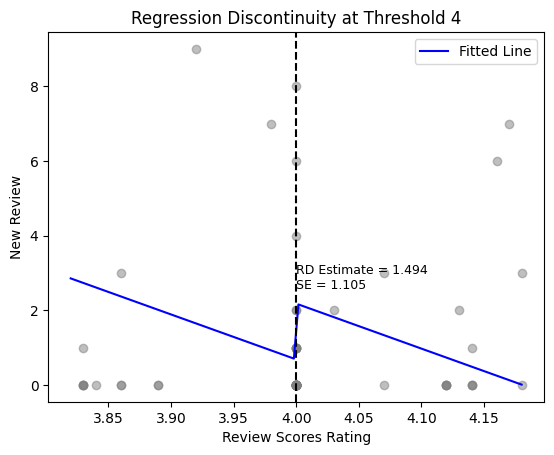

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Sample data loading for New York listings
all_data = pd.read_csv('/content/Amsterdam_listing.csv')

#print(len(all_data['price']))
# Ensure 'price' is a float and remove any non-numeric characters like dollar signs
all_data['price'] = all_data['price'].replace('[\$,]', '', regex=True).astype(float)

# Change the dependent variable to the log of 'number_of_reviews'
all_data['log_new_review'] = np.log(all_data['new_review'] + 1)

dependent_var = 'new_review'  # Now using log of the original dependent variable

# Define a kernel function for weights, triangular kernel as an example
def triangular_kernel(x, bandwidth):
    return np.maximum(1 - np.abs(x) / bandwidth, 0) # You can change this to 'price' or any other variable as needed

# Filter data to keep only observations close to the thresholds
thresholds = [4]
bandwidth = 0.18  # adjust the bandwidth as needed

# Run the regression for each threshold
for threshold in thresholds:
    data_threshold = all_data[(all_data['review_scores_rating'] >= threshold - bandwidth) &
                              (all_data['review_scores_rating'] <= threshold + bandwidth)].copy()

    data_threshold['above_threshold'] = (data_threshold['review_scores_rating'] > threshold).astype(int)

    # Calculate the distance from the threshold for each observation
    data_threshold['distance'] = data_threshold['review_scores_rating'] - threshold

    # Apply the kernel function to get weights
    data_threshold['weights'] = triangular_kernel(data_threshold['distance'], bandwidth)

    # Check if there are enough observations on both sides of the threshold
    if len(data_threshold[data_threshold['above_threshold'] == 0]) > 0 and len(
            data_threshold[data_threshold['above_threshold'] == 1]) > 0:
        # Run the weighted regression including 'price' as a control variable
        X = data_threshold[['review_scores_rating', 'above_threshold', 'price']]
        X = sm.add_constant(X)
        y = data_threshold[dependent_var]
        weights = data_threshold['weights']
        model = sm.WLS(y, X, weights=weights).fit()

        # Get the RD estimate and its standard error
        rd_estimate = model.params['above_threshold']
        rd_se = model.bse['above_threshold']
        print(f'Threshold {threshold}: RD Estimate = {rd_estimate}, Standard Error = {rd_se}')

        # Generate predictions for plotting
        x_plot = np.linspace(threshold - bandwidth, threshold + bandwidth, 100)
        mean_price = data_threshold['price'].mean()
        # Calculate the mean price for the control variable

        # Create the above threshold binary indicator for the prediction data
        above_threshold_plot = (x_plot > threshold).astype(int)

        # Stack the x_plot, above_threshold_plot, and mean_price into x_plot_with_constant
        # You should have a column for the intercept (constant), review_scores_rating, above_threshold, and price
        x_plot_with_constant = sm.add_constant(np.column_stack((x_plot, above_threshold_plot)))
        # Add a column with the mean price for the prediction
        x_plot_with_constant = np.insert(x_plot_with_constant, x_plot_with_constant.shape[1], mean_price, axis=1)

        # Ensure the shape of x_plot_with_constant matches the number of parameters in the model
        if x_plot_with_constant.shape[1] != len(model.params):
            raise ValueError(
                f"The shape of x_plot_with_constant {x_plot_with_constant.shape} does not match the number of parameters in the model {len(model.params)}.")

        # If the shapes match, make predictions
        y_plot = model.predict(x_plot_with_constant)

        # Plot the results
        plt.figure()
        plt.scatter(data_threshold['review_scores_rating'], data_threshold[dependent_var], color='grey', alpha=0.5)
        plt.plot(x_plot, y_plot, color='blue', label='Fitted Line')
        plt.axvline(x=threshold, color='black', linestyle='--')
        plt.xlabel('Review Scores Rating')
        plt.ylabel(dependent_var.replace('_', ' ').title())
        plt.title(f'Regression Discontinuity at Threshold {threshold}')

        # Print the RD estimate and SE on the graph
        plt.text(threshold, max(y_plot) * 0.9, f'RD Estimate = {rd_estimate:.3f}\nSE = {rd_se:.3f}', fontsize=9)

        plt.legend()
     #   plt.savefig(f'output/figure/rating_rd_{threshold}.png', bbox_inches='tight')